In [78]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F

In [79]:
data = pd.read_csv("data/digit-recognizer/train.csv")

In [80]:
labels = np.array(data["label"].values)
labels

array([1, 0, 1, ..., 7, 6, 9], dtype=int64)

In [81]:
# labels = labels[:, None]
# labels

In [82]:
data = data.values

In [83]:
data

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [84]:
data = data[:, 1:]

In [85]:
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [86]:
labels.shape, data.shape

((42000,), (42000, 784))

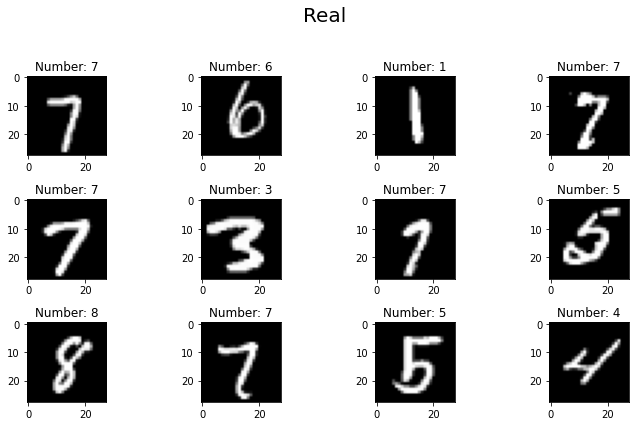

In [87]:
fig, axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
    r_img = np.random.randint(0, high=data.shape[0])
    img = np.reshape(data[r_img, :], (28, 28))
    ax.imshow(img, cmap="gray")
    ax.set_title("Number: %i"%labels[r_img])

plt.suptitle("Real", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95]);

In [88]:
ndata = data / np.max(data)

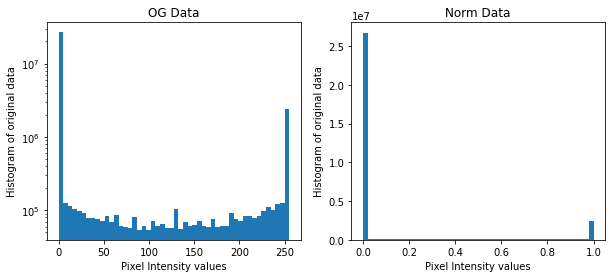

In [89]:
fig, ax = plt.subplots(1, 2,figsize=(10, 4))

for i in range(2):
    ax[i].set_xlabel("Pixel Intensity values")
    ax[i].set_ylabel("Histogram of original data")
ax[0].hist(data.flatten(), 50)
ax[0].set_yscale("log")
ax[1].hist(ndata.flatten(), 50)
ax[0].set_title("OG Data")
ax[1].set_title("Norm Data")
plt.show()

## Setting up DataLoader

In [90]:
tensor_data = torch.tensor(ndata).float()
tensor_label = torch.tensor(labels).long()

train_data, dev_data, train_labels, dev_labels = train_test_split(tensor_data,
                                                                   tensor_label,
                                                                   test_size=0.1)
train_data = TensorDataset(train_data, train_labels)
dev_data = TensorDataset(dev_data, dev_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=test_data.tensors[0].shape[0])

In [128]:
def createModel1():
    """
        Normal model
    """
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784, 64)
            self.hd1 = nn.Linear(64, 32)
            self.hd2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hd1(x))
            x = F.relu(self.hd2(x))
            return F.softmax(self.op(x))
    model = mnistNet()
    Loss = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    return model, Loss, optimizer

In [129]:
def createModel2():
    """
        with log softmax
    """
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784, 64)
            self.hd1 = nn.Linear(64, 32)
            self.hd2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hd1(x))
            x = F.relu(self.hd2(x))
            return torch.log_softmax(self.op(x), axis=1)
    model = mnistNet()
    Loss = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    return model, Loss, optimizer

In [130]:
def createModel3():
    """
        with log softmax and Adam
    """
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784, 64)
            self.hd1 = nn.Linear(64, 32)
            self.hd2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hd1(x))
            x = F.relu(self.hd2(x))
            return torch.log_softmax(self.op(x), axis=1)
    model = mnistNet()
    Loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    return model, Loss, optimizer

In [131]:
# Testing model
model, Loss, optimizer = createModel1()
x, y = next(iter(train_loader))
y_hat = model(x)
loss = Loss(y_hat, y)
print(loss)

tensor(-0.0990, grad_fn=<NllLossBackward0>)


C:\Users\hdotd\AppData\Local\Temp\ipykernel_19716\3241081306.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.op(x))


In [138]:
def train_model(model, Loss, optimizer, train_dataset,
               dev_dataset, epochs=50):
    train_acc = []
    train_loss = []
    dev_acc = []
    
    for i in range(epochs):
        batch_acc = []
        batch_loss = []
        for x, y in train_dataset:
            yh = model(x)
            loss = Loss(yh, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # compute loss and acc
            batch_loss.append(loss.item())
            tv = torch.argmax(yh, axis=1) == y
            ntv = tv.float()
            batch_acc.append(100 * torch.mean(ntv))
        train_acc.append(np.mean(batch_acc))
        train_loss.append(np.mean(batch_loss))
        # test accuracy
        x, y = next(iter(dev_dataset))
        yh = model(x)
        dev_acc.append(100 * torch.mean((torch.argmax(yh, axis=1) == y).float()))
        print("Epochs {0}, Train Accuracy {1}, Valid Accuracy {2}".
              format(i + 1, train_acc[-1], dev_acc[-1]))
    return train_acc, train_loss, dev_acc

C:\Users\hdotd\AppData\Local\Temp\ipykernel_19716\3241081306.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.op(x))


Epochs 1, Train Accuracy 9.713409423828125, Valid Accuracy 9.2619047164917
Epochs 2, Train Accuracy 9.713409423828125, Valid Accuracy 9.2619047164917
Epochs 3, Train Accuracy 14.057211875915527, Valid Accuracy 18.571428298950195
Epochs 4, Train Accuracy 16.531831741333008, Valid Accuracy 17.380952835083008
Epochs 5, Train Accuracy 20.98931884765625, Valid Accuracy 22.785715103149414
Epochs 6, Train Accuracy 21.30129051208496, Valid Accuracy 21.404762268066406
Epochs 7, Train Accuracy 20.825401306152344, Valid Accuracy 21.404762268066406
Epochs 8, Train Accuracy 24.44744110107422, Valid Accuracy 29.499998092651367
Epochs 9, Train Accuracy 35.11262512207031, Valid Accuracy 38.595237731933594
Epochs 10, Train Accuracy 40.42935562133789, Valid Accuracy 43.119049072265625
Epochs 11, Train Accuracy 47.435489654541016, Valid Accuracy 47.9523811340332
Epochs 12, Train Accuracy 49.81757736206055, Valid Accuracy 52.38095474243164
Epochs 13, Train Accuracy 55.3140869140625, Valid Accuracy 56.0714

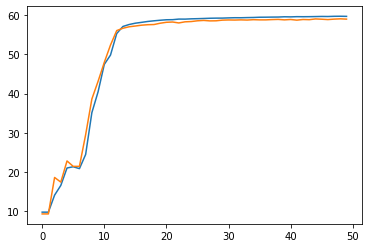

In [139]:
model, Loss, optimizer = createModel1()
train_acc, train_los, dev_acc = train_model(model, Loss, optimizer,
                                           train_loader,
                                           dev_loader)
plt.plot(train_acc, label="train accuracy")
plt.plot(dev_acc, label="dev accuracy");

Epochs 1, Train Accuracy 20.143295288085938, Valid Accuracy 35.761905670166016
Epochs 2, Train Accuracy 68.64688873291016, Valid Accuracy 79.80952453613281
Epochs 3, Train Accuracy 84.87732696533203, Valid Accuracy 86.88095092773438
Epochs 4, Train Accuracy 88.35131072998047, Valid Accuracy 89.0952377319336
Epochs 5, Train Accuracy 90.17290496826172, Valid Accuracy 90.88095092773438
Epochs 6, Train Accuracy 91.27538299560547, Valid Accuracy 92.5238037109375
Epochs 7, Train Accuracy 92.30118560791016, Valid Accuracy 93.04762268066406
Epochs 8, Train Accuracy 93.19479370117188, Valid Accuracy 93.4047622680664
Epochs 9, Train Accuracy 93.94564056396484, Valid Accuracy 94.04761505126953
Epochs 10, Train Accuracy 94.53521728515625, Valid Accuracy 94.71428680419922
Epochs 11, Train Accuracy 95.12214660644531, Valid Accuracy 94.76190185546875
Epochs 12, Train Accuracy 95.52664947509766, Valid Accuracy 95.23809814453125
Epochs 13, Train Accuracy 95.83333587646484, Valid Accuracy 95.35714721679

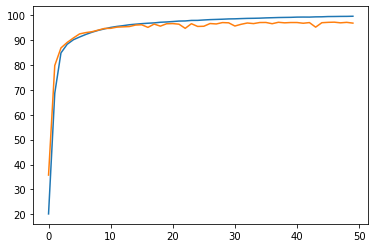

In [140]:
model, Loss, optimizer = createModel2()
train_acc, train_los, dev_acc = train_model(model, Loss, optimizer,
                                           train_loader,
                                           dev_loader)
plt.plot(train_acc, label="train accuracy")
plt.plot(dev_acc, label="dev accuracy");

Epochs 1, Train Accuracy 89.59391021728516, Valid Accuracy 94.33333587646484
Epochs 2, Train Accuracy 94.4294662475586, Valid Accuracy 95.33332824707031
Epochs 3, Train Accuracy 95.07984161376953, Valid Accuracy 95.28571319580078
Epochs 4, Train Accuracy 95.65355682373047, Valid Accuracy 94.80952453613281
Epochs 5, Train Accuracy 96.19818115234375, Valid Accuracy 95.47618865966797
Epochs 6, Train Accuracy 96.37003326416016, Valid Accuracy 95.54761505126953
Epochs 7, Train Accuracy 96.74545288085938, Valid Accuracy 95.16666412353516
Epochs 8, Train Accuracy 96.90672302246094, Valid Accuracy 95.54761505126953
Epochs 9, Train Accuracy 97.0838623046875, Valid Accuracy 96.26190948486328
Epochs 10, Train Accuracy 97.26100158691406, Valid Accuracy 95.21428680419922
Epochs 11, Train Accuracy 97.43549346923828, Valid Accuracy 96.11904907226562
Epochs 12, Train Accuracy 97.34295654296875, Valid Accuracy 95.83332824707031
Epochs 13, Train Accuracy 97.509521484375, Valid Accuracy 95.85714721679688

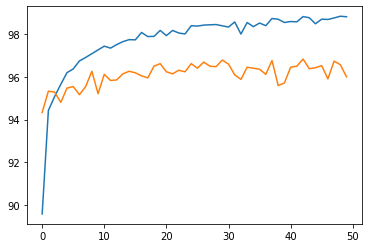

In [141]:
model, Loss, optimizer = createModel3()
train_acc, train_los, dev_acc = train_model(model, Loss, optimizer,
                                           train_loader,
                                           dev_loader)
plt.plot(train_acc, label="train accuracy")
plt.plot(dev_acc, label="dev accuracy");